In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, RobustScaler, FunctionTransformer, LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_predict
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score
)

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

In [3]:
plt.style.use("default")
sns.set_palette("Set2")

RANDOM_STATE = 42
TARGET_COL = "Status"
DROP_COL = ["id", "N_Days"]

# Этап I. Предобработка данных для ML

Загрузим данные, разделим наши признаки на числовые и категориальные, преобразуем таргет в бинарный, разделим на train и test.

In [4]:
df = pd.read_csv("../../data/train.csv").drop(columns=DROP_COL)

In [5]:
target_maps = {"C": 0, "D": 1}

binary_maps = {
    "Drug": {"Placebo": 0, "D-penicillamine": 1},
    "Sex": {"F": 0, "M": 1},
    "Ascites": {"N": 0, "Y": 1},
    "Hepatomegaly": {"N": 0, "Y": 1},
    "Spiders": {"N": 0, "Y": 1}
}

binary_features = list(binary_maps.keys())
multi_category_features = ["Edema", "Stage"]

numeric_features = ["Age", "Bilirubin", "Cholesterol", "Albumin", "Copper",
                    "Alk_Phos", "SGOT", "Tryglicerides", "Platelets", "Prothrombin"]

skewed_numeric = ["Bilirubin", "Cholesterol", "Copper", "Alk_Phos", "SGOT", "Tryglicerides", "Prothrombin"]

symmetric_numeric = [col for col in numeric_features if col not in skewed_numeric]

Исходный таргет с тремя категориями преобразуем в две и будем решать задачу бинарной классификации.

Статус CL значит, что пациент был жив *N_Days* благодаря трансплантации печени. Так как в данных нет признака о трансплантации печени, то невозможно предсказать 2 события: трансплантация печени и что пациент останется жив в течение *N_Days* после операции. Так же класс CL очень малочисленный (миноритарный) 3.5% данных против 33.7% и 62.8% классов D и C соответственно. 
 

- Класс 0, умеренная стадия заболевания — C (пациент жив)
- Класс 1, тяжёлая стадия заболевания — D (летальный исход)

In [6]:
df = df[df[TARGET_COL] != 'CL']

df[TARGET_COL] = df[TARGET_COL].map(target_maps)

df[TARGET_COL].value_counts(normalize=True)

Status
0    0.650721
1    0.349279
Name: proportion, dtype: float64

Разделим все данные на train и test. Подбор методов обработки признаков, настройку гиперпараметров и оценку качества будем проводить только на кросс-валидации на train. Test служит для финальной оценки качества лучшей модели.

In [7]:
X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=RANDOM_STATE
)

In [8]:
print("Распределение таргета на train:")
print(y_train.value_counts(normalize=True))

print("=="*25)

print("Распределение таргета на test:")
print(y_test.value_counts(normalize=True))

Распределение таргета на train:
Status
0    0.650721
1    0.349279
Name: proportion, dtype: float64
Распределение таргета на test:
Status
0    0.650721
1    0.349279
Name: proportion, dtype: float64


### Log-трансформация числовых признаков

Так как EDA показал, что некоторые числовые признаки скошенные и имеют выбросы, то преобразуем данные с помощью логарифмирования и попробуем применить clip.

In [9]:
class BinaryMapper(BaseEstimator, TransformerMixin):
    """
    Превращает бинарные категориальные в 0/1 по заданному словарю.
    """
    def __init__(self, mapping: dict):
        self.mapping = mapping
        self.columns_ = list(mapping.keys())

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_df = X.copy() if isinstance(X, pd.DataFrame) else pd.DataFrame(X, columns=self.columns_)
        for col, mapping in self.mapping.items():
            X_df[col] = X_df[col].map(mapping)
        return X_df

    def get_feature_names_out(self, input_features=None):
        return self.columns_

In [10]:
log = FunctionTransformer(np.log1p, feature_names_out="one-to-one")

# skewed_pipe = Pipeline([
#         ("log", log)
#         ])

processor_log = ColumnTransformer(
        transformers=[
            ("num_skewed", log, skewed_numeric),
            ("binary", BinaryMapper(binary_maps), binary_features),
            ("category", OrdinalEncoder(), multi_category_features)
        ],
        remainder="passthrough",
        verbose_feature_names_out=False
    )

In [11]:
X_proc = processor_log.fit_transform(X_train)
cols = processor_log.get_feature_names_out()

processed_log = pd.DataFrame(X_proc, columns=cols, index=X_train.index)

### Clip числовых признаков

In [12]:
class PercentileClipper(BaseEstimator, TransformerMixin):
    """Обрезает выбросы в указанных колонках по перцентилям."""
    def __init__(self, columns, lower=0.0, upper=99.5):
        self.columns = columns
        self.lower = lower
        self.upper = upper
        self.bounds_ = {}

    def fit(self, X, y=None):
        X = pd.DataFrame(X, columns=self.columns)
        for col in self.columns:
            low = np.percentile(X[col], self.lower)
            up = np.percentile(X[col], self.upper)
            self.bounds_[col] = (low, up)
        return self

    def transform(self, X):
        X_df = pd.DataFrame(X, columns=self.columns)
        for col, (low, up) in self.bounds_.items():
            X_df[col] = X_df[col].clip(low, up)
        return X_df.values
    
    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            return np.array(self.columns, dtype=object)
        return np.asarray(input_features, dtype=object)

In [13]:
processor_clip = ColumnTransformer(
        transformers=[
            ("num_skewed", PercentileClipper(skewed_numeric, upper=99), skewed_numeric),
            ("binary", BinaryMapper(binary_maps), binary_features),
            ("category", OrdinalEncoder(), multi_category_features)
        ],
        remainder="drop",
        verbose_feature_names_out=False
    )

In [14]:
X_proc = processor_clip.fit_transform(X_train)
cols = processor_clip.get_feature_names_out()

processed_clip = pd.DataFrame(X_proc, columns=cols, index=X_train.index)

### Сравним результаты логарифмирования и клипирования на графиках распределения

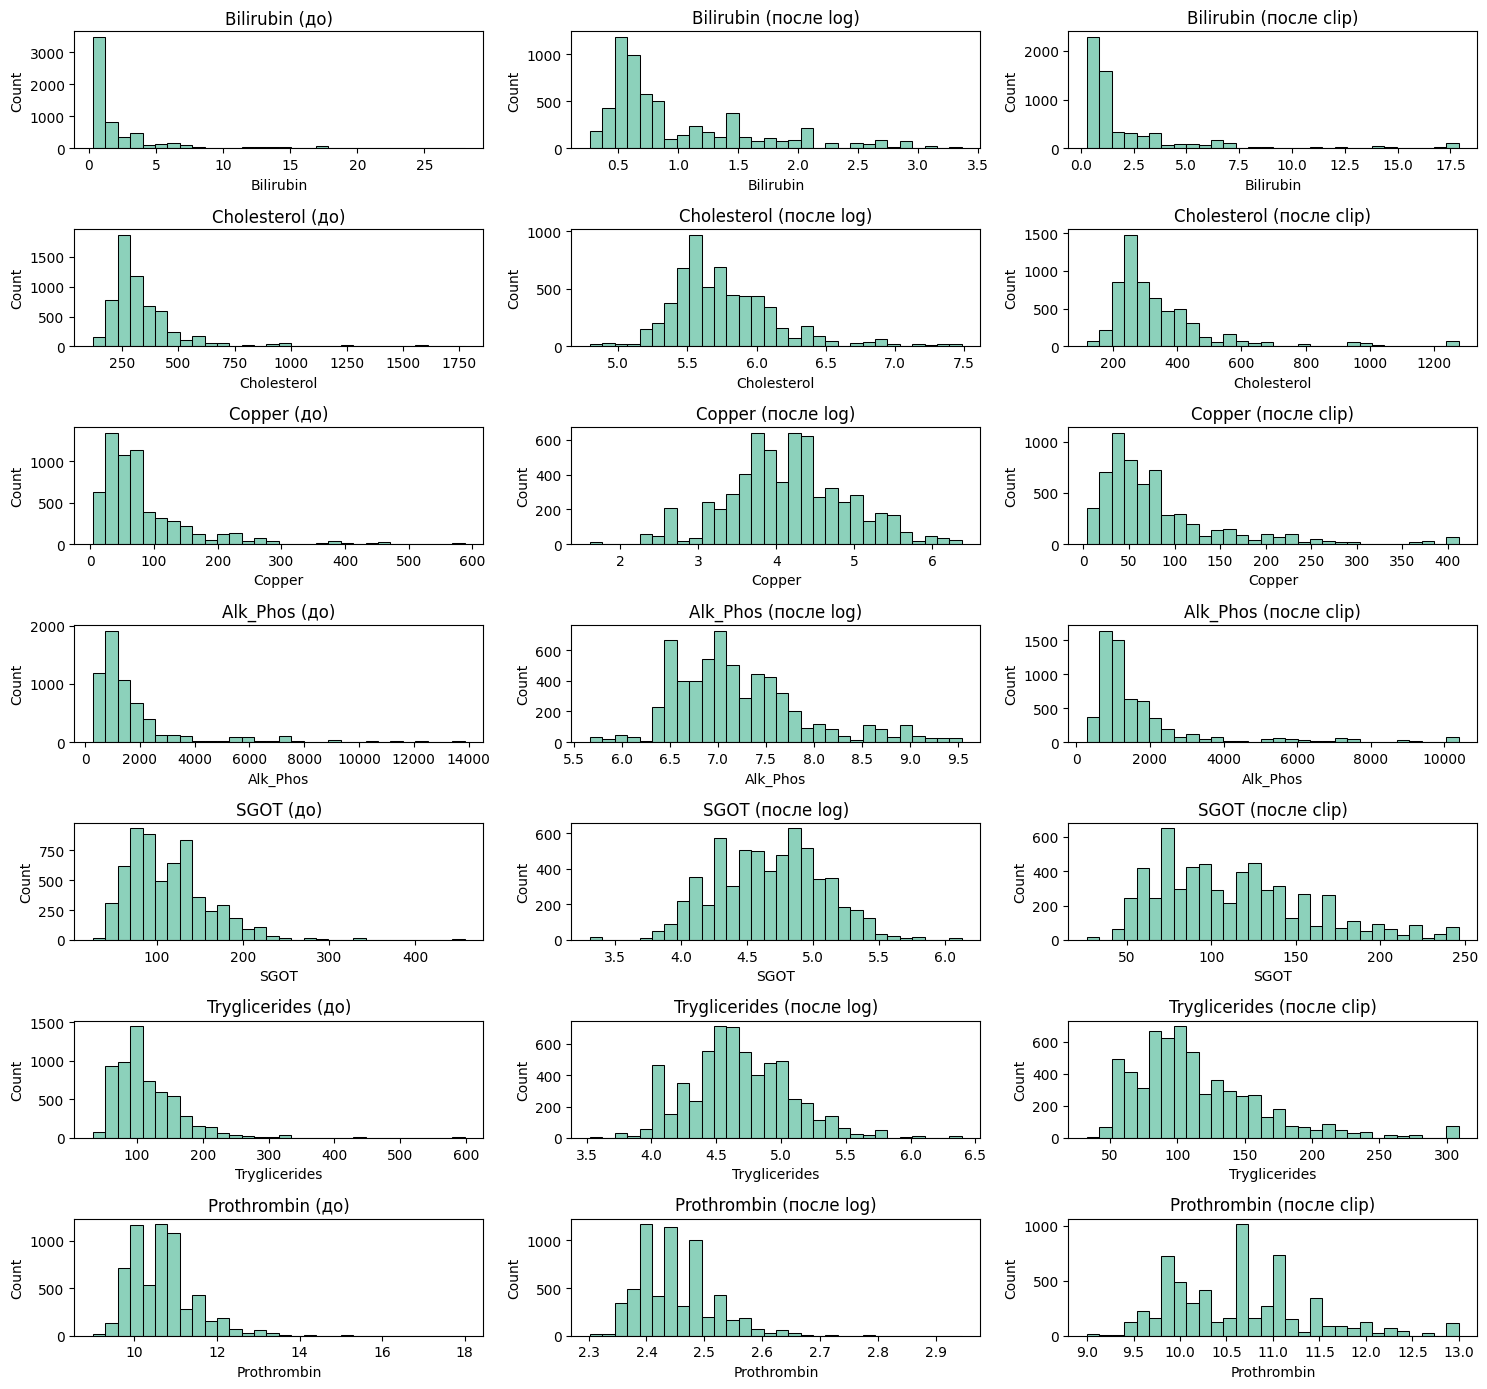

In [15]:
n = len(skewed_numeric)

fig, axes = plt.subplots(n, 3, figsize=(15, n*2), squeeze=False)
bins = 30

for i, col in enumerate(skewed_numeric):
    ax = axes[i, 0]
    sns.histplot(X_train[col], bins=bins, ax=ax)
    ax.set_title(f"{col} (до)")
    ax = axes[i, 1]
    sns.histplot(processed_log[col], bins=bins, ax=ax)
    ax.set_title(f"{col} (после log)")
    ax = axes[i, 2]
    sns.histplot(processed_clip[col], bins=bins, ax=ax)
    ax.set_title(f"{col} (после clip)")

plt.tight_layout()
plt.show()

### Вывод предобработки данных:

Для числовых скошенных признаков выберем стратегию логарифмирования, так как она эффективно сжимает правосторонние хвосты.
Для бинарных признаков и категориальных было произведено кодирование данных.


# Этап II. Дерево решений

In [16]:
#В результате обработки данных
processor = processor_log

X_proc = processor.fit_transform(X_train)
cols = processor.get_feature_names_out()

processed = pd.DataFrame(X_proc, columns=cols, index=X_train.index)

In [17]:
processed.describe().T

,count,mean,std,min,25%,50%,75%,max
Bilirubin,6104.0,0.991686,0.650724,0.262364,0.530628,0.741937,1.360977,3.367296
Cholesterol,6104.0,5.765568,0.389197,4.795791,5.517453,5.700444,5.968708,7.482119
Copper,6104.0,4.138079,0.770228,1.609438,3.688879,4.143135,4.624973,6.378426
Alk_Phos,6104.0,7.208172,0.681448,5.669881,6.727432,7.069023,7.518064,9.537008
SGOT,6104.0,4.664850,0.404322,3.308717,4.343156,4.681668,4.934114,6.127415
Tryglicerides,6104.0,4.673538,0.390380,3.526361,4.442651,4.653960,4.927254,6.395262
Prothrombin,6104.0,2.451499,0.065183,2.302585,2.397895,2.451005,2.484907,2.944439
Drug,6104.0,0.490498,0.499951,0.000000,0.000000,0.000000,1.000000,1.000000
Sex,6104.0,0.070773,0.256467,0.000000,0.000000,0.000000,0.000000,1.000000
Ascites,6104.0,0.048820,0.215510,0.000000,0.000000,0.000000,0.000000,1.000000


Будем использовать StratifiedKFold, чтобы в каждом фолде была соблюдена пропорция классов. Установим 5 фолдов.

In [18]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# 1. Decision Tree

In [19]:
decision_tree = Pipeline([
    ("preprocess", processor),
    ("dectree", DecisionTreeClassifier(
        random_state=RANDOM_STATE))
])

param_grid = {
    'dectree__max_depth': [3, 5, 7, None],
    'dectree__min_samples_split': [2, 5, 10, 15],
    'dectree__min_samples_leaf': [5, 10, 15, 20],
    'dectree__criterion': ['gini', 'entropy'],
    'dectree__class_weight': [None, 'balanced']
}

gs_dt= GridSearchCV(
    decision_tree,
    param_grid=param_grid,
    cv=skf,
    scoring="recall",
    n_jobs=-1
)

gs_dt.fit(X_train, y_train)
print("Дерево решений:")
print("Лучшие параметры:", gs_dt.best_params_)
print("Лучший recall на кросс-валидации:", gs_dt.best_score_)

Дерево решений:
Лучшие параметры: {'dectree__class_weight': 'balanced', 'dectree__criterion': 'gini', 'dectree__max_depth': 7, 'dectree__min_samples_leaf': 20, 'dectree__min_samples_split': 2}
Лучший recall на кросс-валидации: 0.7875196534397643


In [20]:
y_pred_dt = cross_val_predict(
    gs_dt.best_estimator_,
    X_train, y_train,
    cv=skf,
    n_jobs=-1
)

print("Отчёт по классам (модель decision tree):")
print(classification_report(y_train, y_pred_dt))

Отчёт по классам (модель decision tree):
              precision    recall  f1-score   support

           0       0.87      0.78      0.83      3972
           1       0.66      0.79      0.72      2132

    accuracy                           0.78      6104
   macro avg       0.77      0.79      0.77      6104
weighted avg       0.80      0.78      0.79      6104



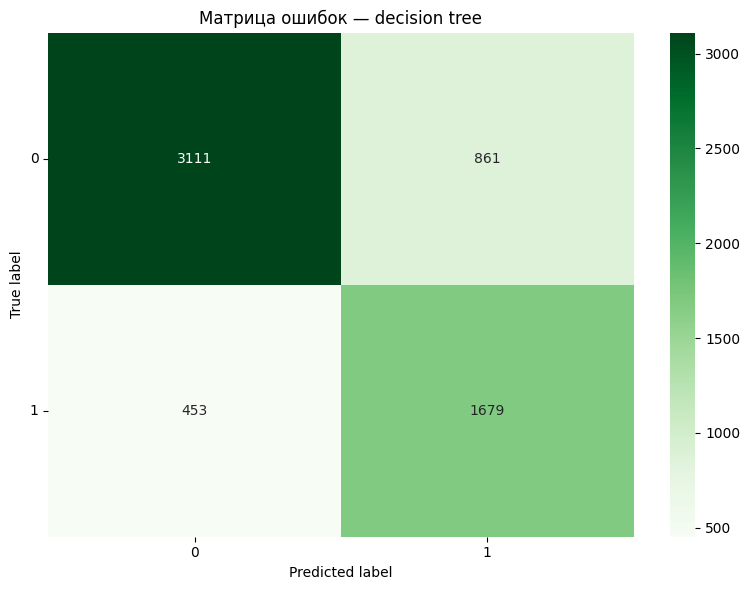

In [21]:
cm_dt = confusion_matrix(y_train, y_pred_dt)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_dt, annot=True, fmt="d", cmap="Greens")
plt.title("Матрица ошибок — decision tree")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.xticks([0.5, 1.5], ["0", "1"])
plt.yticks([0.5, 1.5], ["0", "1"], rotation=0)
plt.tight_layout()
plt.show()

# 2. Decision Tree + Downsampling класса большинства

Используем простой способ, чтобы выровнять пропорцию классов: просто удалим некоторые объекты класса большинства.

In [22]:
pipeline_us = ImbPipeline(steps=[
    ("preprocess", processor),
    ("undersample", RandomUnderSampler(random_state=RANDOM_STATE)),
    ("dectree", DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_grid = {
    'dectree__max_depth': [3, 5, 7, None],
    'dectree__min_samples_split': [2, 5, 10, 15],
    'dectree__min_samples_leaf': [5, 10, 15, 20],
    'dectree__criterion': ['gini', 'entropy'],
    'dectree__class_weight': [None, 'balanced']
}

gs_us_dt = GridSearchCV(
    pipeline_us,
    param_grid=param_grid,
    cv=skf,
    scoring="recall",
    n_jobs=-1
)

gs_us_dt.fit(X_train, y_train)
print("RandomDownSampler + дерево решений")
print("Лучшие параметры:", gs_us_dt.best_params_)
print("Лучший recall на кросс-валидации:", gs_us_dt.best_score_)

RandomDownSampler + дерево решений
Лучшие параметры: {'dectree__class_weight': None, 'dectree__criterion': 'entropy', 'dectree__max_depth': 3, 'dectree__min_samples_leaf': 5, 'dectree__min_samples_split': 2}
Лучший recall на кросс-валидации: 0.7907983419643544


In [23]:
y_pred_us_dt = cross_val_predict(
    gs_us_dt.best_estimator_,
    X_train, y_train,
    cv=skf,
    n_jobs=-1
)

print("Отчёт по классам (модель с RandomUnderSampler):")
print(classification_report(y_train, y_pred_us_dt))

Отчёт по классам (модель с RandomUnderSampler):
              precision    recall  f1-score   support

           0       0.87      0.76      0.81      3972
           1       0.64      0.79      0.71      2132

    accuracy                           0.77      6104
   macro avg       0.76      0.78      0.76      6104
weighted avg       0.79      0.77      0.78      6104



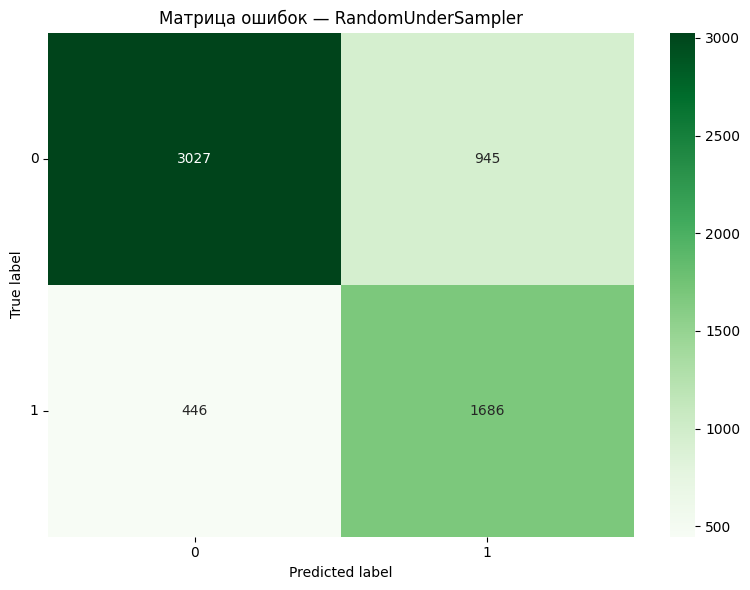

In [24]:
cm = confusion_matrix(y_train, y_pred_us_dt)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens")
plt.title("Матрица ошибок — RandomUnderSampler")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.xticks([0.5, 1.5], ["0", "1"])
plt.yticks([0.5, 1.5], ["0", "1"], rotation=0)
plt.tight_layout()
plt.show()

В данном случае recall остаётся на том же уровне 0.79, но появились потери в precision 0.66 -> 0.64.

## 3. Decision Tree + Upsampling класса меньшинства

In [25]:
pipeline_os = ImbPipeline(steps=[
    ("preprocess", processor),
    ("oversample", RandomOverSampler(random_state=RANDOM_STATE)),
    ("dectree", DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_grid = {
    'dectree__max_depth': [3, 5, 7, None],
    'dectree__min_samples_split': [2, 5, 10, 15],
    'dectree__min_samples_leaf': [5, 10, 15, 20],
    'dectree__criterion': ['gini', 'entropy']
}

gs_os_dt = GridSearchCV(
    pipeline_os,
    param_grid=param_grid,
    cv=skf,
    scoring="recall",
    n_jobs=-1
)

gs_os_dt.fit(X_train, y_train)
print("RandomOverSampler + дерево решений")
print("Лучшие параметры:", gs_os_dt.best_params_)
print("Лучший recall на кросс-валидации:", gs_os_dt.best_score_)

RandomOverSampler + дерево решений
Лучшие параметры: {'dectree__criterion': 'gini', 'dectree__max_depth': 7, 'dectree__min_samples_leaf': 10, 'dectree__min_samples_split': 2}
Лучший recall на кросс-валидации: 0.7800266077338348


In [26]:
y_pred_os_dt = cross_val_predict(
    gs_os_dt.best_estimator_,
    X_train, y_train,
    cv=skf,
    n_jobs=-1
)

print("Отчёт по классам (модель с RandomOverSampler):")
print(classification_report(y_train, y_pred_os_dt))

Отчёт по классам (модель с RandomOverSampler):
              precision    recall  f1-score   support

           0       0.87      0.82      0.84      3972
           1       0.70      0.78      0.74      2132

    accuracy                           0.80      6104
   macro avg       0.79      0.80      0.79      6104
weighted avg       0.81      0.80      0.81      6104



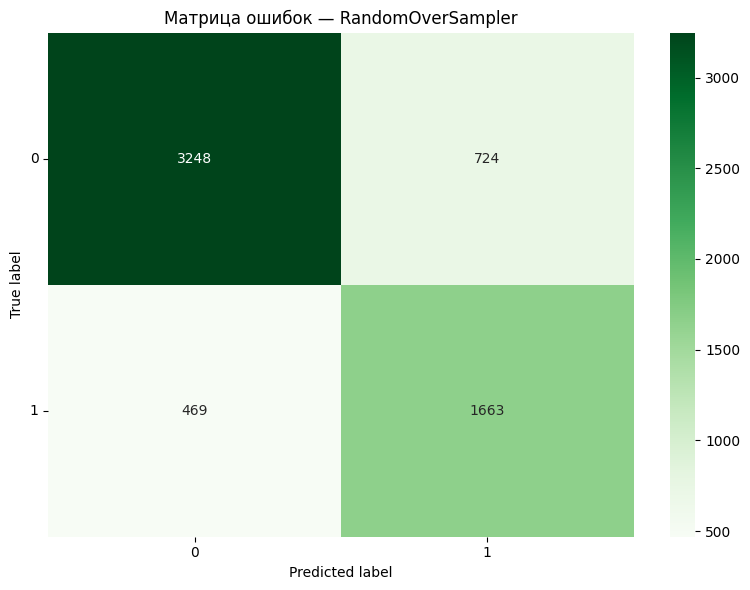

In [27]:
cm = confusion_matrix(y_train, y_pred_os_dt)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens")
plt.title("Матрица ошибок — RandomOverSampler")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.xticks([0.5, 1.5], ["0", "1"])
plt.yticks([0.5, 1.5], ["0", "1"], rotation=0)
plt.tight_layout()
plt.show()

Здесь чуть теряем в recall 0.79 -> 0.78, зато возрастаем в precision 0.64 -> 0.70

## 4. Decision Tree + SMOTE

In [28]:
pipeline_smote = ImbPipeline(steps=[
    ("preprocess", processor),
    ("smote", SMOTE(random_state=RANDOM_STATE, k_neighbors=5),
    ),
    ("dectree", DecisionTreeClassifier(random_state=RANDOM_STATE))
])


param_grid = {
    'dectree__max_depth': [3, 5, 7, None],
    'dectree__min_samples_split': [2, 5, 10, 15],
    'dectree__min_samples_leaf': [5, 10, 15, 20],
    'dectree__criterion': ['gini', 'entropy']
}

gs_smote_dt = GridSearchCV(
    pipeline_smote,
    param_grid=param_grid,
    cv=skf,
    scoring="recall",
    n_jobs=-1
)

gs_smote_dt.fit(X_train, y_train)
print("SMOTE + дерево решений")
print("Лучшие параметры:", gs_smote_dt.best_params_)
print("Лучший recall на кросс-валидации:", gs_smote_dt.best_score_)

SMOTE + дерево решений
Лучшие параметры: {'dectree__criterion': 'gini', 'dectree__max_depth': 7, 'dectree__min_samples_leaf': 5, 'dectree__min_samples_split': 2}
Лучший recall на кросс-валидации: 0.7265560576574199


In [29]:
y_pred_smote_dt = cross_val_predict(
    gs_smote_dt.best_estimator_,
    X_train, y_train,
    cv=skf,
    n_jobs=-1
)

print("Отчёт по классам (модель SMOTE):")
print(classification_report(y_train, y_pred_smote_dt))

Отчёт по классам (модель SMOTE):
              precision    recall  f1-score   support

           0       0.85      0.85      0.85      3972
           1       0.73      0.73      0.73      2132

    accuracy                           0.81      6104
   macro avg       0.79      0.79      0.79      6104
weighted avg       0.81      0.81      0.81      6104



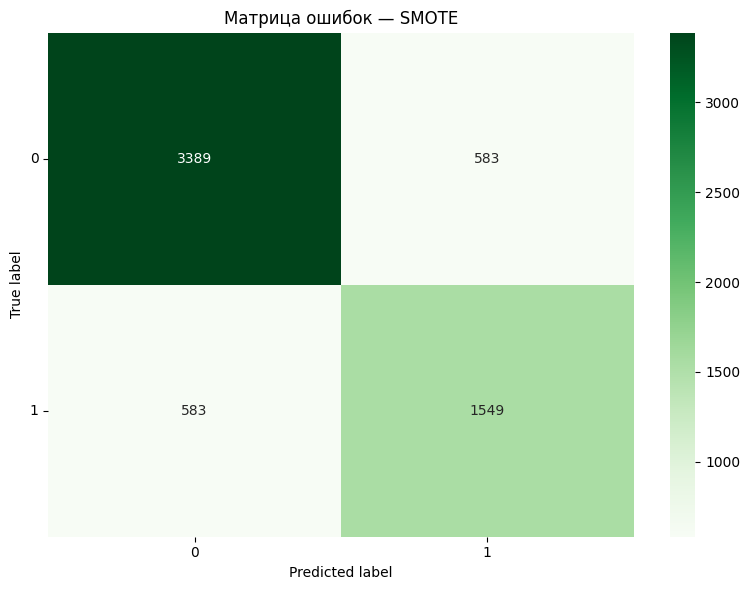

In [33]:
cm = confusion_matrix(y_train, y_pred_smote_dt)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens")
plt.title("Матрица ошибок — SMOTE")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.xticks([0.5, 1.5], ["0", "1"])
plt.yticks([0.5, 1.5], ["0", "1"], rotation=0)
plt.tight_layout()
plt.show()

В данной модели сравнялись метрики recall и precision и равны 0.73. Precision имеет лучший результат из вышеперечисленных моделей, но в данном случае снизился recall, который имеет здесь **важное** значение, так как со снижением recall мы пропускаем действительно больного пациента. 

Среди всех проделанных моделей оптимальной по балансу метрик recall и precision является модель *Decision Tree + Upsampling класса меньшинства* с метриками:

- recall - 0.78
- precision - 0.70

# Этап III. Случайный лес

In [34]:
#В результате обработки данных
processor = processor_log

X_proc = processor.fit_transform(X_train)
cols = processor.get_feature_names_out()

processed = pd.DataFrame(X_proc, columns=cols, index=X_train.index)

## 1. Random Forest

In [35]:
random_forest = Pipeline([
    ("preprocess", processor),
    ("ranforest", RandomForestClassifier(
        random_state=RANDOM_STATE, n_jobs=-1))
])

param_grid = {
    'ranforest__n_estimators': [50, 100],
    'ranforest__max_depth': [None, 10, 20],
    'ranforest__min_samples_split': [2, 5],
    'ranforest__min_samples_leaf': [1, 2],
    'ranforest__max_features': ['sqrt', 'log2'],
    'ranforest__bootstrap': [True, False],
    'ranforest__class_weight': ['balanced'],
    'ranforest__criterion': ['gini', 'entropy']

}

gs_rf= GridSearchCV(
    random_forest,
    param_grid=param_grid,
    cv=skf,
    scoring="recall",
    n_jobs=-1
)

gs_rf.fit(X_train, y_train)
print("Случайный лес:")
print("Лучшие параметры:", gs_rf.best_params_)
print("Лучший recall на кросс-валидации:", gs_rf.best_score_)

Случайный лес:
Лучшие параметры: {'ranforest__bootstrap': False, 'ranforest__class_weight': 'balanced', 'ranforest__criterion': 'entropy', 'ranforest__max_depth': 10, 'ranforest__max_features': 'sqrt', 'ranforest__min_samples_leaf': 1, 'ranforest__min_samples_split': 5, 'ranforest__n_estimators': 50}
Лучший recall на кросс-валидации: 0.7715814009741508


In [36]:
y_pred_rf = cross_val_predict(
    gs_rf.best_estimator_,
    X_train, y_train,
    cv=skf,
    n_jobs=-1
)

print("Отчёт по классам (модель Случайный лес):")
print(classification_report(y_train, y_pred_rf))

Отчёт по классам (модель Случайный лес):
              precision    recall  f1-score   support

           0       0.88      0.87      0.87      3972
           1       0.76      0.77      0.77      2132

    accuracy                           0.84      6104
   macro avg       0.82      0.82      0.82      6104
weighted avg       0.84      0.84      0.84      6104



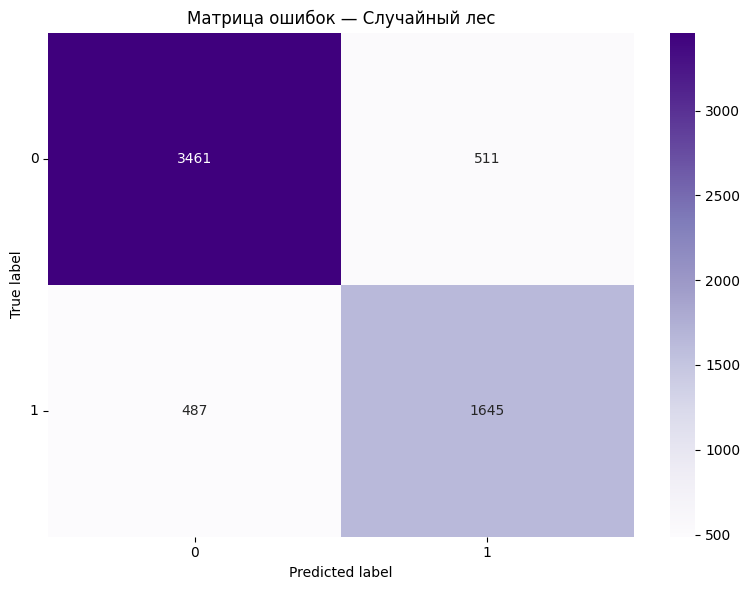

In [37]:
cm_rf = confusion_matrix(y_train, y_pred_rf)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Purples")
plt.title("Матрица ошибок — Случайный лес")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.xticks([0.5, 1.5], ["0", "1"])
plt.yticks([0.5, 1.5], ["0", "1"], rotation=0)
plt.tight_layout()
plt.show()

Метрики сравнялись, стали лучше предсказывать выживаемость, возможно это связано с дисбалансом классов, где смертность является миноритарным классом. Recall стал чуть хуже, чем в деревьях решений. Попробуем применить методы устранения дисбаланса классов.

# 2. Random Forest + Downsampling класса большинства

In [38]:
pipeline_us = ImbPipeline(steps=[
    ("preprocess", processor),
    ("undersample", RandomUnderSampler(random_state=RANDOM_STATE)),
    ("ranforest", RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1))
])

param_grid = {
    'ranforest__n_estimators': [50, 100],
    'ranforest__max_depth': [None, 10, 20],
    'ranforest__min_samples_split': [2, 5],
    'ranforest__min_samples_leaf': [1, 2],
    'ranforest__max_features': ['sqrt', 'log2'],
    'ranforest__bootstrap': [True, False],
    'ranforest__class_weight': ['balanced'],
    'ranforest__criterion': ['gini', 'entropy']

}

gs_us_rf = GridSearchCV(
    pipeline_us,
    param_grid=param_grid,
    cv=skf,
    scoring="recall",
    n_jobs=-1
)

gs_us_rf.fit(X_train, y_train)
print("RandomDownSampler + случайный лес")
print("Лучшие параметры:", gs_us_rf.best_params_)
print("Лучший recall на кросс-валидации:", gs_us_rf.best_score_)

RandomDownSampler + случайный лес
Лучшие параметры: {'ranforest__bootstrap': True, 'ranforest__class_weight': 'balanced', 'ranforest__criterion': 'gini', 'ranforest__max_depth': None, 'ranforest__max_features': 'sqrt', 'ranforest__min_samples_leaf': 1, 'ranforest__min_samples_split': 5, 'ranforest__n_estimators': 100}
Лучший recall на кросс-валидации: 0.8241206803663511


In [39]:
y_pred_us_rf = cross_val_predict(
    gs_us_rf.best_estimator_,
    X_train, y_train,
    cv=skf,
    n_jobs=-1
)

print("Отчёт по классам (модель с RandomUnderSampler):")
print(classification_report(y_train, y_pred_us_rf))

Отчёт по классам (модель с RandomUnderSampler):
              precision    recall  f1-score   support

           0       0.90      0.84      0.87      3972
           1       0.73      0.82      0.77      2132

    accuracy                           0.83      6104
   macro avg       0.81      0.83      0.82      6104
weighted avg       0.84      0.83      0.83      6104



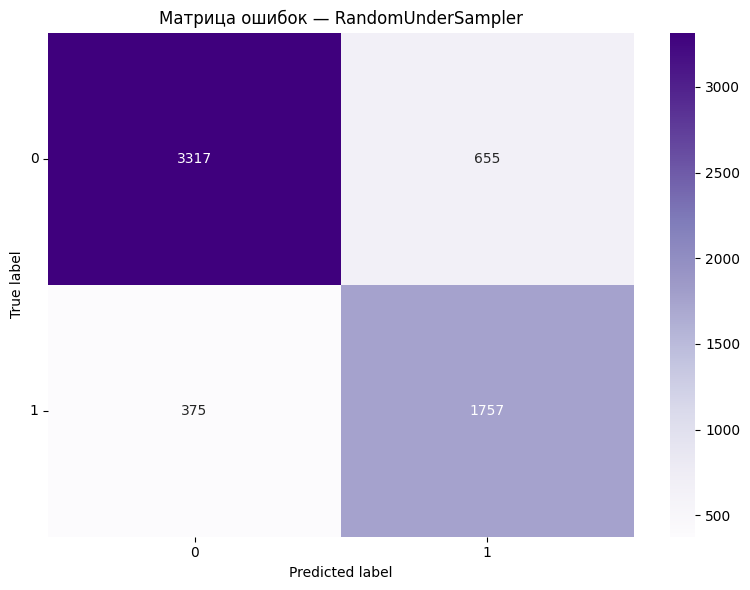

In [40]:
cm = confusion_matrix(y_train, y_pred_us_rf)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples")
plt.title("Матрица ошибок — RandomUnderSampler")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.xticks([0.5, 1.5], ["0", "1"])
plt.yticks([0.5, 1.5], ["0", "1"], rotation=0)
plt.tight_layout()
plt.show()

Результат сильно улучшился. Recall возрос до 0.82, а precision остался на уровне 0.73. 

## 3. Random Forest + Upsampling класса меньшинства

In [41]:
pipeline_us = ImbPipeline(steps=[
    ("preprocess", processor),
    ("oversample", RandomOverSampler(random_state=RANDOM_STATE)),
    ("ranforest", RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1))
])

param_grid = {
    'ranforest__n_estimators': [50, 100],
    'ranforest__max_depth': [None, 10, 20],
    'ranforest__min_samples_split': [2, 5],
    'ranforest__min_samples_leaf': [1, 2],
    'ranforest__max_features': ['sqrt', 'log2'],
    'ranforest__bootstrap': [True, False],
    'ranforest__class_weight': ['balanced'],
    'ranforest__criterion': ['gini', 'entropy']

}

gs_os_rf = GridSearchCV(
    pipeline_us,
    param_grid=param_grid,
    cv=skf,
    scoring="recall",
    n_jobs=-1
)

gs_os_rf.fit(X_train, y_train)
print("RandomOverSampler + случайный лес")
print("Лучшие параметры:", gs_os_rf.best_params_)
print("Лучший recall на кросс-валидации:", gs_os_rf.best_score_)

RandomOverSampler + случайный лес
Лучшие параметры: {'ranforest__bootstrap': True, 'ranforest__class_weight': 'balanced', 'ranforest__criterion': 'gini', 'ranforest__max_depth': 10, 'ranforest__max_features': 'sqrt', 'ranforest__min_samples_leaf': 2, 'ranforest__min_samples_split': 5, 'ranforest__n_estimators': 50}
Лучший recall на кросс-валидации: 0.7744059988345373


In [42]:
y_pred_os_rf = cross_val_predict(
    gs_os_rf.best_estimator_,
    X_train, y_train,
    cv=skf,
    n_jobs=-1
)

print("Отчёт по классам (модель с RandomOverSampler):")
print(classification_report(y_train, y_pred_os_rf))

Отчёт по классам (модель с RandomOverSampler):
              precision    recall  f1-score   support

           0       0.88      0.87      0.87      3972
           1       0.76      0.77      0.77      2132

    accuracy                           0.84      6104
   macro avg       0.82      0.82      0.82      6104
weighted avg       0.84      0.84      0.84      6104



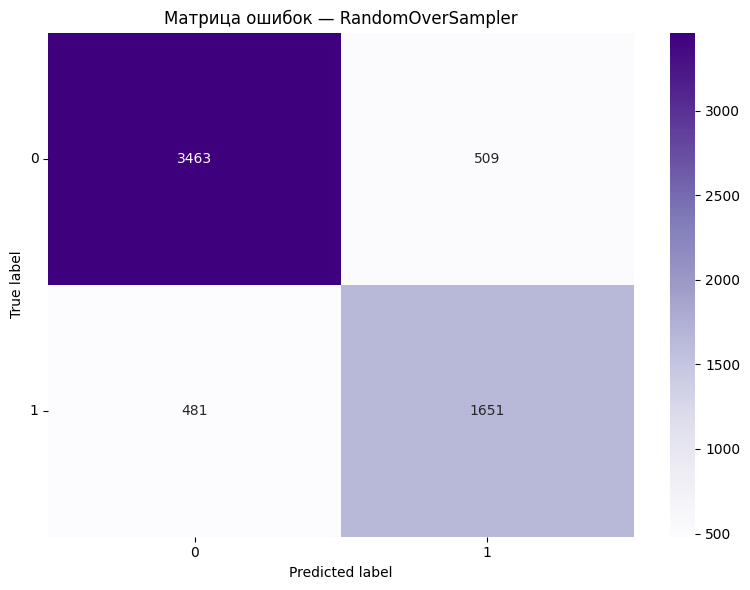

In [43]:
cm = confusion_matrix(y_train, y_pred_os_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples")
plt.title("Матрица ошибок — RandomOverSampler")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.xticks([0.5, 1.5], ["0", "1"])
plt.yticks([0.5, 1.5], ["0", "1"], rotation=0)
plt.tight_layout()
plt.show()

Получилось хуже, так как снизился recall до 0.77

# 4. Random Forest + SMOT

In [44]:
pipeline_smote = ImbPipeline(steps=[
    ("preprocess", processor),
    ("smote", SMOTE(random_state=RANDOM_STATE, k_neighbors=5),
    ),
    ("ranforest", RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1))
])


param_grid = {
    'ranforest__n_estimators': [50, 100],
    'ranforest__max_depth': [None, 10, 20],
    'ranforest__min_samples_split': [2, 5],
    'ranforest__min_samples_leaf': [1, 2],
    'ranforest__max_features': ['sqrt', 'log2'],
    'ranforest__bootstrap': [True, False],
    'ranforest__class_weight': ['balanced'],
    'ranforest__criterion': ['gini', 'entropy']

}

gs_smote_rf = GridSearchCV(
    pipeline_smote,
    param_grid=param_grid,
    cv=skf,
    scoring="recall",
    n_jobs=-1
)

gs_smote_rf.fit(X_train, y_train)
print("SMOTE + случайный лес")
print("Лучшие параметры:", gs_smote_rf.best_params_)
print("Лучший recall на кросс-валидации:", gs_smote_rf.best_score_)

SMOTE + случайный лес
Лучшие параметры: {'ranforest__bootstrap': True, 'ranforest__class_weight': 'balanced', 'ranforest__criterion': 'gini', 'ranforest__max_depth': 20, 'ranforest__max_features': 'sqrt', 'ranforest__min_samples_leaf': 2, 'ranforest__min_samples_split': 2, 'ranforest__n_estimators': 100}
Лучший recall на кросс-валидации: 0.7650240239249706


In [45]:
y_pred_smote_rf = cross_val_predict(
    gs_smote_rf.best_estimator_,
    X_train, y_train,
    cv=skf,
    n_jobs=-1
)

print("Отчёт по классам (модель SMOTE):")
print(classification_report(y_train, y_pred_smote_rf))

Отчёт по классам (модель SMOTE):
              precision    recall  f1-score   support

           0       0.87      0.88      0.88      3972
           1       0.77      0.77      0.77      2132

    accuracy                           0.84      6104
   macro avg       0.82      0.82      0.82      6104
weighted avg       0.84      0.84      0.84      6104



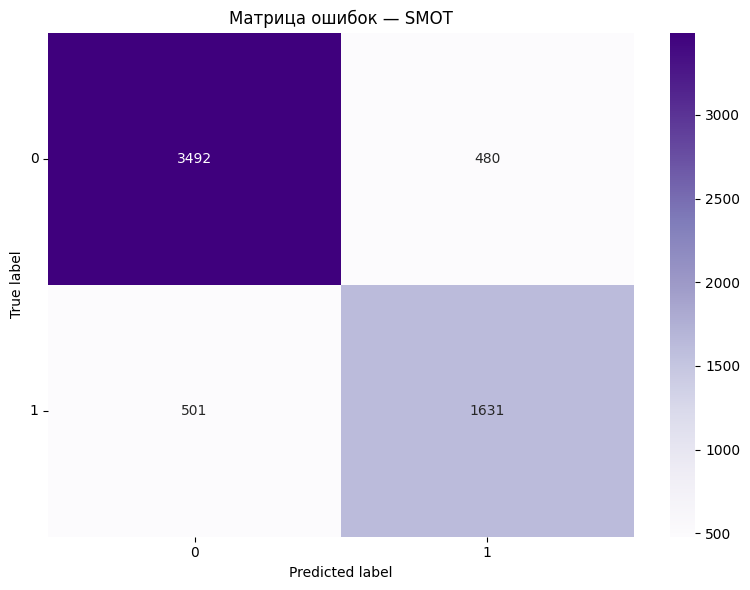

In [46]:
cm = confusion_matrix(y_train, y_pred_smote_rf)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples")
plt.title("Матрица ошибок — SMOT")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.xticks([0.5, 1.5], ["0", "1"])
plt.yticks([0.5, 1.5], ["0", "1"], rotation=0)
plt.tight_layout()
plt.show()

Вывод: 

В контексте поставленной задачи лучше, чем все остальные, показала себя модель *Random Forest + Downsampling класса большинства* с recall = 0.82 и precision = 0.73.
Есть модели с лучшим precision, но так как важнее не пропускать пациентов, которые действительно больны (FN), то опираемся на метрику recall.

# Изменение порога

Попробуем изменить порог для выбранной модели *Random Forest + Downsampling класса большинства*.

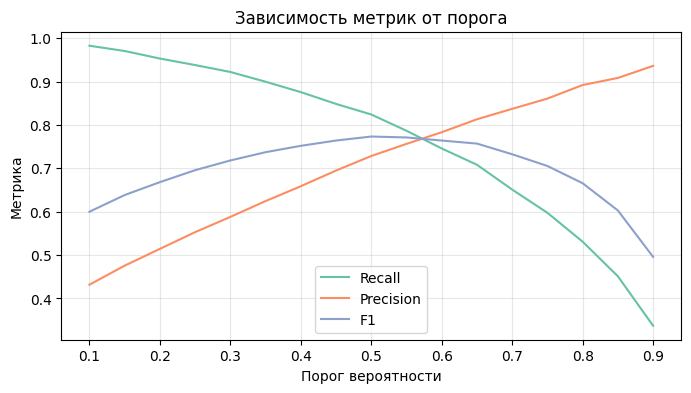

In [47]:
y_proba_us_rf = cross_val_predict(
    gs_us_rf.best_estimator_,
    X_train, y_train,
    cv=skf,
    method="predict_proba",
    n_jobs=-1
)[:, 1]

thresholds = np.arange(0.1, 0.91, 0.05)
recalls, precisions, f1s = [], [], []

for thr in thresholds:
    y_thr = (y_proba_us_rf >= thr).astype(int)
    recalls.append(recall_score(y_train, y_thr))
    precisions.append(precision_score(y_train, y_thr))
    f1s.append(f1_score(y_train, y_thr))

plt.figure(figsize=(8, 4))
plt.plot(thresholds, recalls, label="Recall")
plt.plot(thresholds, precisions, label="Precision")
plt.plot(thresholds, f1s, label="F1")
plt.xlabel("Порог вероятности")
plt.ylabel("Метрика")
plt.legend()
plt.grid(alpha=0.3)
plt.title("Зависимость метрик от порога")
plt.show()

# Этап IV. Проверка на тесте

In [48]:
best_params = gs_us_rf.best_params_
print(f"Лучшие параметры: {best_params}")

Лучшие параметры: {'ranforest__bootstrap': True, 'ranforest__class_weight': 'balanced', 'ranforest__criterion': 'gini', 'ranforest__max_depth': None, 'ranforest__max_features': 'sqrt', 'ranforest__min_samples_leaf': 1, 'ranforest__min_samples_split': 5, 'ranforest__n_estimators': 100}


In [49]:
final_pipeline = ImbPipeline([
    ("preprocess", processor),
    ("undersample", RandomUnderSampler(random_state=RANDOM_STATE)),
    ("ranforest", RandomForestClassifier(
        random_state=RANDOM_STATE,
        bootstrap=best_params["ranforest__bootstrap"],
        criterion=best_params["ranforest__criterion"],
        max_depth=best_params["ranforest__max_depth"],
        max_features=best_params["ranforest__max_features"],
        min_samples_leaf=best_params["ranforest__min_samples_leaf"],
        min_samples_split=best_params["ranforest__min_samples_split"],
        n_estimators=best_params["ranforest__n_estimators"],
        class_weight=best_params["ranforest__class_weight"],
        n_jobs=-1,
    ))
])

# обучение на всём train
final_pipeline.fit(X_train, y_train)

,steps,"[('preprocess', ...), ('undersample', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num_skewed', ...), ('binary', ...), ...]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False


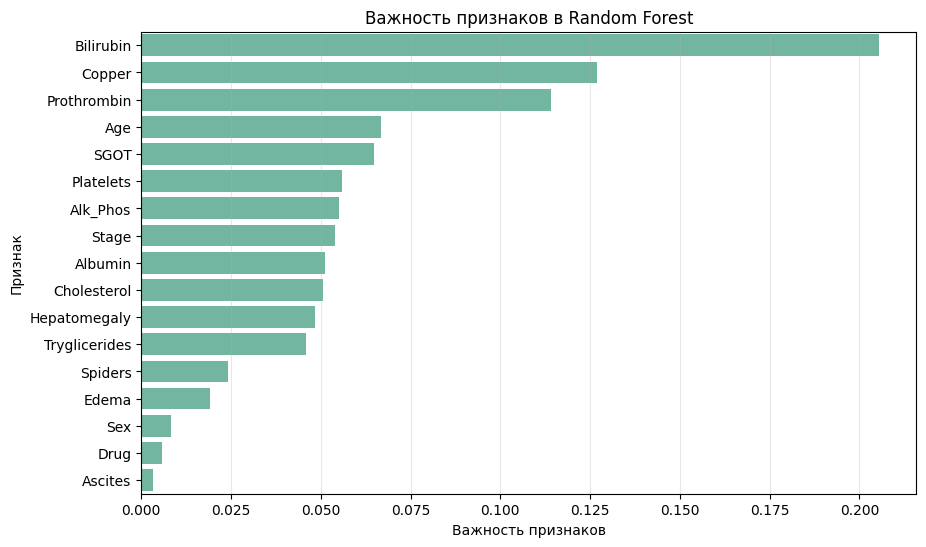

In [50]:
preprocess_step = final_pipeline.named_steps["preprocess"]
feature_names = preprocess_step.get_feature_names_out()

ranforest_step = final_pipeline.named_steps["ranforest"]
coefs = ranforest_step.feature_importances_

feature_importances = pd.DataFrame({
    'feature': feature_names,
    'importance': coefs,
}).sort_values('importance', ascending=False)

# Построение горизонтального bar plot
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importances, y='feature', x='importance')
plt.xlabel('Важность признаков')
plt.ylabel('Признак')

plt.title('Важность признаков в Random Forest')
plt.grid(axis='x', alpha=0.3)
plt.show()

In [51]:
y_predict_test = final_pipeline.predict(X_test)

In [52]:
print(f"Отчёт по классам на тесте:")
print(classification_report(y_test, y_predict_test))

Отчёт по классам на тесте:
              precision    recall  f1-score   support

           0       0.89      0.81      0.85       993
           1       0.70      0.81      0.75       533

    accuracy                           0.81      1526
   macro avg       0.79      0.81      0.80      1526
weighted avg       0.82      0.81      0.82      1526



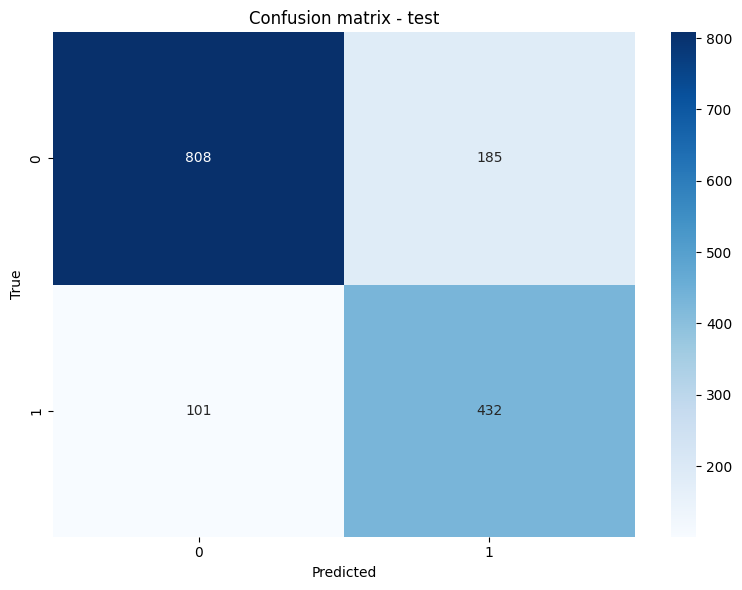

In [53]:
cm_test = confusion_matrix(y_test, y_predict_test)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion matrix - test")
plt.tight_layout()
plt.show()

В данном случае значения метрик не сильно отличаются от метрик на тренировочных данных. Порог не менялся, оставили по умолчанию 0.5.

Это позволяет найти баланс между большим процентом определения тяжело больных пациентов и меньшим процентом потерь здоровых пациентов среди тех, кого модель назвала тяжёлыми.

# Выводы

**Предобработка:**

Оптимальной является стратегия log для "скошенных" числовых признаков. Бинарные закодированы в 0/1, многокатегориальные — в коды (OrdinalEncoder).

**Моделирование:**

Проведена оценка разных моделей Деревьей решений и Случайного леса, а так же методов для борьбы дисбаланса классов. Лучший результат по метрикам показала модель *Random Forest + Downsampling класса большинства*.

**Результаты:**

На тесте модель показывает recall класса 1 = 0.81 и приемлемый precision = 0.70, что делает её оптимальной при определении действительно тяжёлых пациентов и ошибок на пациентов с положительным прогнозом. 

Важнейшие признаки: Bilirubin, Cooper, Prothrombin, Age, SGOT.